In [48]:
import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parse_results import *
from utils.utils import *
from db_utils.utils import *
from db_utils.query_storage import *
import networkx as nx
from cardinality_estimation.algs import *
import numpy as np
from cardinality_estimation.losses import *
#from cardinality_estimation.join_loss import JoinLoss, get_join_cost_sql, get_leading_hint
from cardinality_estimation.join_loss import *
from cardinality_estimation.nn import update_samples

from sql_rep.utils import nodes_to_sql, path_to_join_order
#from cvxopt import matrix, solvers
#import cvxopt
import cvxpy as cp
import time
import copy
from multiprocessing import Pool
# FIXME: separate jupyter utils files especially for plotting utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
def get_qerr(true, est):
    qerrs = []
    for k,y in true.items():
        yhat = est[k]
        qerrs.append(max( y / yhat, yhat / y))
    return sum(qerrs) / len(qerrs)

def eval_alg(sql, y, yhat, join_graph):
    env = JoinLoss(COST_MODEL, "ubuntu", "", "localhost", 5432, "imdb")

    print("qerr: ", get_qerr(y, yhat))
    est_costs, opt_costs, est_plans, opt_plans, est_sqls, opt_sqls = \
                env.compute_join_order_loss([sql], [join_graph],
                        [y], [yhat], None, True, num_processes=1, postgres=True, pool=None)

    print("jerr: {}".format(est_costs[0]-opt_costs[0]))
    plot_explain_join_order(est_plans[0], y, yhat, None, "Plan based on Estimates")
    plt.show()
    # FIXME:
    #plot_explain_join_order(opt_plans[0], y, y, None, "Plan based on true values")
    plot_explain_join_order(opt_plans[0], {}, {}, None, "Plan based on true values")

    plt.show()
    return opt_costs[0], opt_plans[0]

def get_all_errors(y, yhat, qrep):
    env = JoinLoss(COST_MODEL, "ubuntu", "", "localhost", 5432, "imdb")
    flow_env = PlanError(COST_MODEL, "flow-loss")
    plan_env = PlanError(COST_MODEL, "plan-loss", "ubuntu", "", "localhost", 5432, "imdb")
    qerr = get_qerr(y, yhat)
    sql = qrep["sql"]
    join_graph = qrep["join_graph"]
    opt_costs, est_costs, est_plans, opt_plans, est_sqls, opt_sqls = flow_env.compute_loss([qrep], [yhat])
    flow_err = est_costs[0] - opt_costs[0]
    opt_costs, est_costs, est_plans, opt_plans, est_sqls, opt_sqls = plan_env.compute_loss([qrep], [yhat], 
                                                                true_cardinalities=[y], join_graphs=[join_graph],
                                                                                          pool=pool)
    plan_err = est_costs[0] - opt_costs[0]
    est_costs, opt_costs, est_plans, opt_plans, est_sqls, opt_sqls = \
            env.compute_join_order_loss([sql], [join_graph],
            [y], [yhat], None, True, num_processes=1, postgres=True, pool=None)
    join_err = est_costs[0] - opt_costs[0]
    
    return qerr,flow_err,plan_err,join_err

def plot_flow_path(edges, subsetg, solx, final_node, source_node, fn=None):
    source_node = tuple("s")
    cur_node = final_node
    edge_dict = {}
    edge_widths = {}
    for i, e in enumerate(edges):
        edge_dict[e] = i
        edge_widths[e] = solx[i]
        print(e, type(e))
        edge_dict[tuple((e[1], e[0]))] = i
        edge_widths[tuple((e[1], e[0]))] = solx[i]

    all_edges = []
    best_path_nodes = []
    while True:
        out_edges = subsetg.out_edges(cur_node)
        min_cost_edge = None
        min_cost = -100000000000
    
        for edge in out_edges:
            idx = edge_dict[edge]
            wt = solx[idx]
            if wt > min_cost:
                min_cost_edge = edge
                min_cost = wt
        all_edges.append(min_cost_edge)
        best_path_nodes.append(cur_node)
        cur_node = min_cost_edge[1]
        all_edges.append(min_cost_edge)
        if cur_node == source_node:
            best_path_nodes.append(cur_node) 
            break

    print("going to draw flow path")
    draw_graph(subsetg, highlight_nodes=best_path_nodes, edge_widths=edge_widths, save_to=fn)
    

In [55]:
QUERY_DIR = "./our_dataset/queries/"
query = "6a/6a110.pkl"
#query = "4a/4a10.pkl"
#query = "2a/2a300.pkl"
#query = "8a/8a141.pkl"
#query = "8a/8a91.pkl"
#query = "8a/8a127.pkl"
#query = "9a/b1be52459332af1a4f140611e0aa9037ac712eda.pkl"
#query = "11b/47e3b09c19496ff2d5817e5bc935ebb3e8379183.pkl"                                                         

#query = "1a/1a1835.pkl"
#query = "9b/7e37de327d93cc29605213bde97e8b0f1ebe1ecd.pkl"
#query = "2b/2b46.pkl"

## adding NON primary penalty fails for these
#query = "5a/5a749.pkl"

## works for nil8, but not nil9, ugh ughly
#query = "2b/2b238.pkl"

## fails for nil13 example
#query = "10a/1b7d9459de56e6c72e71cae1f55eb3b281602323.pkl"
#query = "2b/2b46.pkl"
#query = "2a/2a308.pkl"

## this was a disaster for true runtime
#query = "2b/2b381.pkl"


## shows improvement of 13, adding NON primary key index penalty
#query = "1a/1a1180.pkl"
#query = "2a/2a380.pkl"

## shows improvement of 13 over nli8
#query = "2a/2a308.pkl"

#COST_MODEL = "nested_loop_index8"
COST_MODEL = "cm1"
COST_KEY = COST_MODEL + "cost"


#QUERY_DIR = "./debug_sqls/"
#query = "1.pkl"
#query = "2.pkl"

qfn = QUERY_DIR + query
postgres = Postgres()
true_alg = TrueCardinalities()

USER = "ubuntu"
PWD = ""
HOST = "localhost"
PORT = 5432
DB_NAME = "imdb"
SAVE_DIR = "./QueryLabPlots/"

# for join loss computations

pool = Pool(2)

In [56]:
qrep = load_sql_rep(qfn)
join_graph = qrep["join_graph"]
subset_graph = qrep["subset_graph"]
sql = qrep["sql"]
print(sql)

update_samples([qrep], 0, COST_MODEL, 1)

SELECT COUNT(*)
FROM title as t,
movie_info as mi1,
kind_type as kt,
info_type as it1,
info_type as it3,
info_type as it4,
movie_info_idx as mii1,
movie_info_idx as mii2,
aka_name as an,
name as n,
info_type as it5,
person_info as pi1,
cast_info as ci,
role_type as rt
WHERE
t.id = mi1.movie_id
AND t.id = ci.movie_id
AND t.id = mii1.movie_id
AND t.id = mii2.movie_id
AND mii2.movie_id = mii1.movie_id
AND mi1.movie_id = mii1.movie_id
AND mi1.info_type_id = it1.id
AND mii1.info_type_id = it3.id
AND mii2.info_type_id = it4.id
AND t.kind_id = kt.id
AND (kt.kind IN ('episode','movie'))
AND (t.production_year <= 2015)
AND (t.production_year >= 1975)
AND (mi1.info IN ('Action','Animation','Comedy','Crime','Drama','Family','Horror','Romance','Short','Thriller'))
AND (it1.id IN ('108','3'))
AND it3.id = '100'
AND it4.id = '101'
AND (mii2.info ~ '^(?:[1-9]\d*|0)?(?:\.\d+)?$' AND mii2.info::float <= 11.0)
AND (mii2.info ~ '^(?:[1-9]\d*|0)?(?:\.\d+)?$' AND 7.0 <= mii2.info::float)
AND (mii1.info ~ '

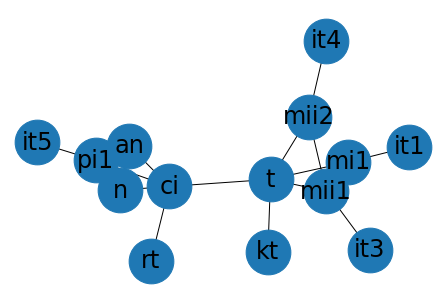

In [57]:
nx.draw(join_graph, pos=nx.spring_layout(join_graph), with_labels=True, node_size=2000, font_size=24)
plt.savefig(SAVE_DIR + "join_graph.png")

qerr:  126653.66344212355
compute postgres join error took:  2.494654417037964
jerr: 13660751.23


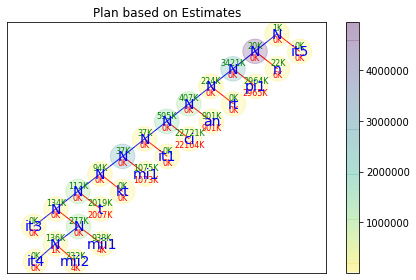

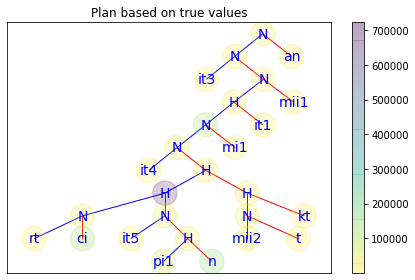

['Aggregate', 'Nested Loop', 'Nested Loop', 'Seq Scan', 'Nested Loop', 'Hash Join', 'Nested Loop', 'Nested Loop', 'Seq Scan', 'Hash Join', 'Hash Join', 'Nested Loop', 'Seq Scan', 'Index Scan', 'Hash', 'Nested Loop', 'Seq Scan', 'Hash Join', 'Bitmap Heap Scan', 'Bitmap Index Scan', 'Hash', 'Seq Scan', 'Hash', 'Hash Join', 'Nested Loop', 'Bitmap Heap Scan', 'Bitmap Index Scan', 'Index Scan', 'Hash', 'Seq Scan', 'Index Scan', 'Hash', 'Seq Scan', 'Index Scan', 'Index Only Scan']
[1244391.08, 1244389.2, 1243885.31, 2.41, 1243875.36, 1243247.8, 1243243.23, 1130482.28, 2.41, 1130425.23, 1085244.38, 145155.98, 1.15, 125014.37, 217107.47, 217107.47, 2.41, 216930.28, 55350.04, 2544.88, 159800.28, 159800.28, 41210.69, 41210.69, 39939.57, 31051.18, 8380.83, 8.1, 1.09, 1.09, 29.12, 2.41, 2.41, 1.42, 1.74]


In [58]:
y = true_alg.test([qrep])
y_pg = postgres.test([qrep])

#random_alg = Random()
#true_random = TrueRandom()
#y_rand = random_alg.test([qrep])
#y_true_rand = true_random.test([qrep])
sql = fix_query(sql)

opt_cost, opt_plan = eval_alg(sql, y[0], y_pg[0], join_graph)
node_types = extract_values(opt_plan[0][0], "Node Type")
costs = extract_values(opt_plan[0][0], "Total Cost")
print(node_types)
print(costs)
#print(opt_plan)

In [39]:
def dont_change_subset(k,v):
    ret = None
    #if "t" in k and "mi1" in k:
    if "ci" in k:
        ret = v
    else:
        ret = v + random.randint(-1000000,1000000)
    if ret <= 0:
        ret = 1
    return ret

def change_subset(k,v):
    ret = None
    # if "n" in k or "ci" in k:
    if "kt" in k and "t" in k and len(k) == 2:
       # ret = v -= random.randint(-100000,100000)
        ret = 10000
    #if "n" in k :
       # ret = random.randint(-100000,100000)
    #elif "rt" in k and "ci" in k and len(k) == 2:
        #ret = v * 1
    elif "rt" in k and "ci" in k and "t" in k and len(k) == 3:
        ret = 108 * 1000
    elif "kt" in k and "ci" in k and "t" in k and len(k) == 3:
        ret = 108 * 1000
    elif "kt" in k and "ci" in k and "t" in k and "rt" in k and len(k) == 4:
        ret = 108 * 1000
    else:
        ret = v
        #ret = v + random.randint(-100,100)
    if ret <= 0:
        ret = 1
    return ret

def small_change(k,v):
    v += random.randint(-10000,10000)
    if v <= 0:
        v = 1
    return v
        
test_ests = {}
num_changed = 0
#for k,v in y[0].items():
for k,v in y_pg[0].items():
    test_ests[k] = change_subset(k,v)
    if test_ests[k] != v:
        num_changed += 1
        
print("total: {}, num changed: {}".format(len(y[0]), num_changed))
#eval_alg(sql, y[0], test_ests, join_graph)

total: 1413, num changed: 4


trying to reverse edge directions!


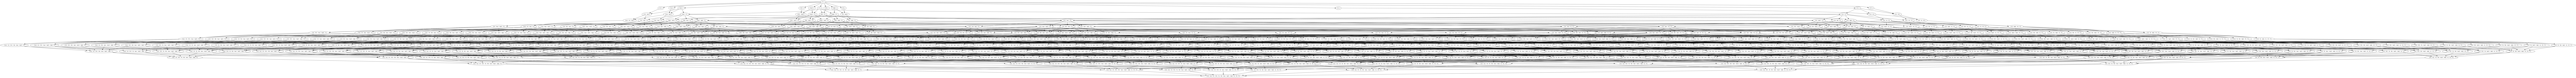

In [17]:
subsetg = copy.deepcopy(qrep["subset_graph"])
#add_single_node_edges(subsetg)
qrep["subset_graph"] = subsetg
final_node = [n for n,d in subsetg.in_degree() if d==0][0]
source_node = tuple("s")
fn = SAVE_DIR + "SubqueryGraphWithoutSource.png"
draw_graph(subsetg, save_to=fn)

trying to reverse edge directions!


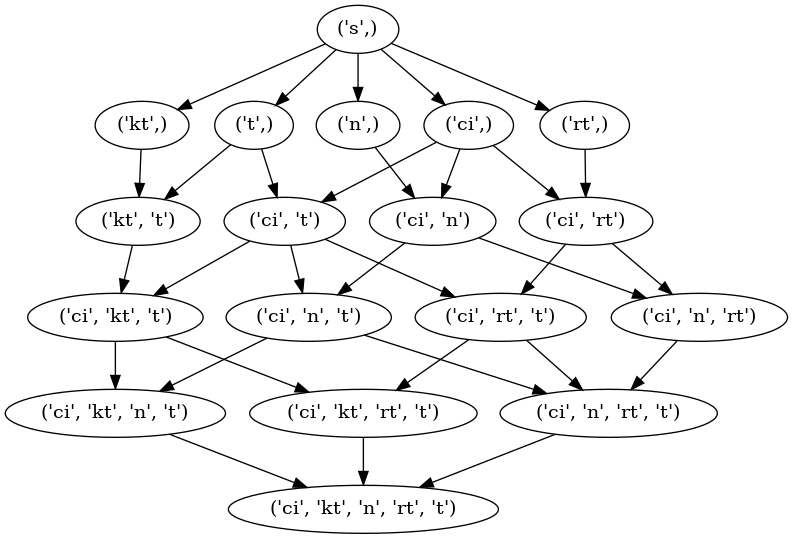

In [9]:
subsetg = copy.deepcopy(qrep["subset_graph"])
add_single_node_edges(subsetg)
qrep["subset_graph"] = subsetg
final_node = [n for n,d in subsetg.in_degree() if d==0][0]
source_node = tuple("s")
fn = SAVE_DIR + "SubqueryGraphWithSource.png"
draw_graph(subsetg, save_to=fn)

trying to reverse edge directions!


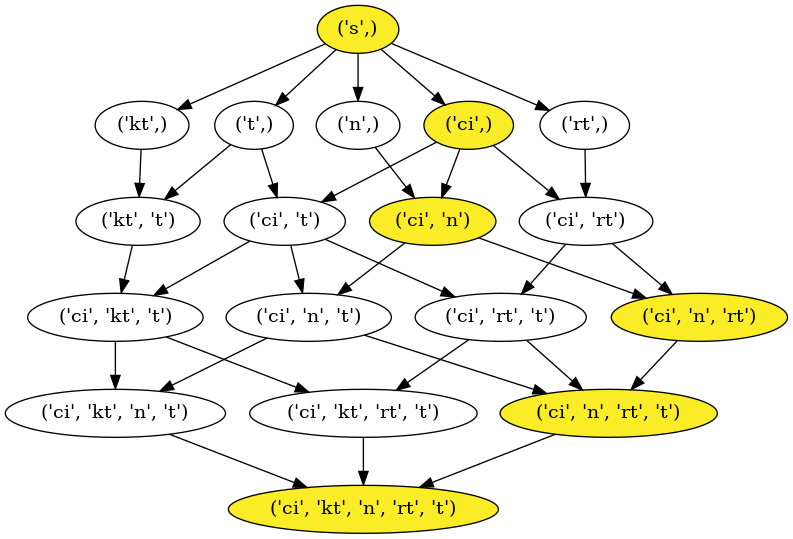

In [10]:
COST_MODEL = "cm1"

compute_costs(subsetg, COST_MODEL)
# we need to recalculate the weights here
path = nx.shortest_path(subsetg, final_node, source_node, weight=COST_MODEL + "cost")
fn = SAVE_DIR + "SubqueryGraphShortestPath.png"
draw_graph(subsetg, highlight_nodes=path, save_to=fn)

In [307]:
path = path[0:-1]
print(path)
join_order = [tuple(sorted(x)) for x in path_to_join_order(path)]
join_order.reverse()
sql_to_exec = nodes_to_sql(join_order, join_graph)
#sql_to_exec = sql_to_exec.replace("title as t CROSS JOIN kind_type as kt", "kind_type as kt CROSS JOIN title as t")
#print(sql_to_exec)
#sql_to_exec = fix_query(sql_to_exec)
print(sql_to_exec)

[('ci', 'kt', 'n', 'rt', 't'), ('ci', 'n', 'rt', 't'), ('ci', 'n', 'rt'), ('ci', 'n'), ('ci',)]
SELECT COUNT(*) FROM cast_info as ci CROSS JOIN name as n CROSS JOIN role_type as rt CROSS JOIN title as t CROSS JOIN kind_type as kt WHERE  kt.kind IN ('movie') AND  n.gender IN ('f') AND  rt.role IN ('actor', 'director') AND  t.production_year <= 2015 AND ci.person_id = n.id AND ci.role_id = rt.id AND t.id = ci.movie_id AND t.kind_id = kt.id


In [308]:
cost_sql, est_cost, est_explain = get_join_cost_sql(sql_to_exec, None, y[0], join_graph, "ubuntu", "", "localhost", 5432, "imdb", 
                                                    COST_MODEL)
jerr = est_cost - opt_cost
jerr_ratio = est_cost / opt_cost
print("est_cost: {}, opt_cost: {}, jerr: {}, jerr_ratio: {}".format(est_cost, opt_cost, jerr, jerr_ratio))
extract_values(est_explain[0][0], "Node Type")
print(est_explain)
#print(cost_sql)


est_cost: 1241631.28, opt_cost: 713234.99, jerr: 528396.29, jerr_ratio: 1.7408445987766248
[([{'Plan': {'Node Type': 'Aggregate', 'Strategy': 'Plain', 'Partial Mode': 'Simple', 'Parallel Aware': False, 'Startup Cost': 1241631.27, 'Total Cost': 1241631.28, 'Plan Rows': 1, 'Plan Width': 8, 'Plans': [{'Node Type': 'Hash Join', 'Parent Relationship': 'Outer', 'Parallel Aware': False, 'Join Type': 'Inner', 'Startup Cost': 101693.94, 'Total Cost': 1241554.34, 'Plan Rows': 30772, 'Plan Width': 0, 'Inner Unique': True, 'Hash Cond': '(t.kind_id = kt.id)', 'Plans': [{'Node Type': 'Nested Loop', 'Parent Relationship': 'Outer', 'Parallel Aware': False, 'Join Type': 'Inner', 'Startup Cost': 101692.84, 'Total Cost': 1241175.75, 'Plan Rows': 89574, 'Plan Width': 4, 'Inner Unique': True, 'Plans': [{'Node Type': 'Hash Join', 'Parent Relationship': 'Outer', 'Parallel Aware': False, 'Join Type': 'Inner', 'Startup Cost': 101692.41, 'Total Cost': 1199933.27, 'Plan Rows': 90695, 'Plan Width': 4, 'Inner Uniq

cm1


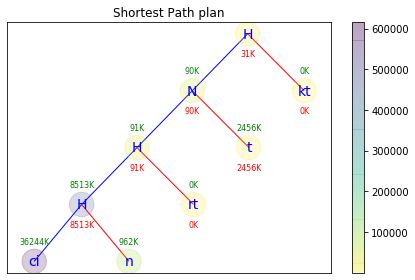

In [309]:
plot_explain_join_order(est_explain, y[0], y[0], None, "Shortest Path plan")
plt.show()
print(COST_MODEL)

In [310]:
costs = extract_values(est_explain[0][0], "Total Cost")
node_types = extract_values(est_explain[0][0], "Node Type")

#print(len(costs))
print(node_types)
print(costs)

['Aggregate', 'Hash Join', 'Nested Loop', 'Hash Join', 'Hash Join', 'Seq Scan', 'Hash', 'Bitmap Heap Scan', 'Bitmap Index Scan', 'Hash', 'Seq Scan', 'Index Scan', 'Hash', 'Seq Scan']
[1241631.28, 1241554.34, 1241175.75, 1199933.27, 1169692.18, 615130.44, 85819.56, 85819.56, 17872.03, 1.15, 1.15, 0.45, 1.09, 1.09]


In [311]:
edges, c, A, b, G, h = construct_lp(subsetg, cost_key=COST_KEY)

In [312]:
print(A.shape)
print("A rank: ", np.linalg.matrix_rank(A))
print(b)
nodes = list(subsetg.nodes())
nodes.sort()

(18, 31)
A rank:  17
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]


In [313]:
start = time.time()
n = len(edges)
x = cp.Variable(n)
constraints = [A @ x == b, G @ x <= 0]
prob = cp.Problem(cp.Minimize(c.T@x), constraints)
prob.solve(verbose=True)
print(prob.value)
print(x.value)
print("linear program took: ", time.time()-start)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +4.719e+07  +4.719e+07  +1e+08  2e-02  4e-01  1e+00  3e+06    ---    ---    1  1  - |  -  - 
 1  +3.352e+07  +3.639e+07  +2e+08  3e-01  4e-01  3e+06  5e+06  0.9890  8e-01   0  0  0 |  0  0
 2  +5.734e+06  +6.592e+06  +3e+07  2e-01  3e-02  9e+05  9e+05  0.9002  4e-02   0  0  0 |  0  0
 3  +6.807e+06  +6.830e+06  +3e+06  1e-01  1e-03  2e+04  1e+05  0.9890  3e-02   0  0  0 |  0  0
 4  +5.841e+06  +5.865e+06  +6e+06  8e-02  1e-03  2e+04  2e+05  0.5598  6e-01   0  0  1 |  0  0
 5  +8.855e+06  +8.860e+06  +1e+06  8e-02  1e-04  5e+03  3e+04  0.9109  4e-02   0  0  1 |  0  0
 6  +9.458e+06  +9.463e+06  +8e+05  7e-02  9e-05  4e+03  2e+04  0.4715  3e-01   0  1  1 |  0  0
 7  +8.933e+06  +8.938e+06  +1e+06  4e-02  9e-05  6e+03  4e+04  0.2715  8e-01   0  1  1 |  0  0
 8  +9.667e+06  +9.668e+06  +1e+05  2e-02  8e-

(('ci',), ('s',)) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'kt', 'n', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'kt', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'n', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 't'), ('ci', 'kt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 't'), ('ci', 'n', 't')) <class 'tuple'>
(('ci', 'kt', 'rt', 't'), ('ci', 'kt', 't')) <class 'tuple'>
(('ci', 'kt', 'rt', 't'), ('ci', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 't'), ('ci', 't')) <class 'tuple'>
(('ci', 'kt', 't'), ('kt', 't')) <class 'tuple'>
(('ci', 'n'), ('ci',)) <class 'tuple'>
(('ci', 'n'), ('n',)) <class 'tuple'>
(('ci', 'n', 'rt'), ('ci', 'n')) <class 'tuple'>
(('ci', 'n', 'rt'), ('ci', 'rt')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'n', 'rt')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'n', 't')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'rt', 't')) <class 'tuple'>
(('ci', 'n', 't'), ('ci', 'n')) <class 'tuple'>
(('ci', 'n

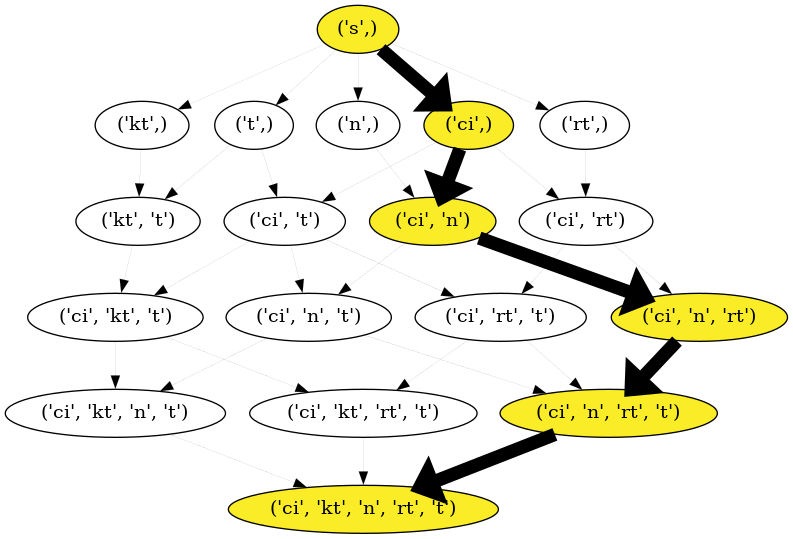

In [314]:
solx = np.array(x.value)
#draw_graph(subsetg, highlight_nodes=best_path_nodes, edge_widths=edge_widths)
fn = SAVE_DIR + "SubqueryGraphLinearProgram.png"
#draw_graph(subsetg, highlight_nodes=path, save_to=fn)
plot_flow_path(edges, subsetg, solx, final_node, source_node, fn)

In [315]:
edges, costs, A, b, G, h = construct_lp(subsetg, cost_key=COST_KEY)

n = len(edges)
P = np.zeros((len(edges),len(edges)))
for i,c in enumerate(costs):
    P[i,i] = c
    
q = np.zeros(len(edges))
x = cp.Variable(n)
#prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
#                 [G @ x <= h,
#                  A @ x == b])
prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
                 [A @ x == b])
prob.solve(verbose=True)
qsolx = np.array(x.value)
print(qsolx)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 31, constraints m = 18
          nnz(P) + nnz(A) = 93
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+00   1.10e+07   1.00e-01   1.18e-04s
  50   1.2350e+06   1.48e-09   1.48e-04   1.00e-01   4.14e-04s
plsh   1.2350e+06   8.88e-17   5.14e-10   ------

(('ci',), ('s',)) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'kt', 'n', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'kt', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'n', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 't'), ('ci', 'kt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 't'), ('ci', 'n', 't')) <class 'tuple'>
(('ci', 'kt', 'rt', 't'), ('ci', 'kt', 't')) <class 'tuple'>
(('ci', 'kt', 'rt', 't'), ('ci', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 't'), ('ci', 't')) <class 'tuple'>
(('ci', 'kt', 't'), ('kt', 't')) <class 'tuple'>
(('ci', 'n'), ('ci',)) <class 'tuple'>
(('ci', 'n'), ('n',)) <class 'tuple'>
(('ci', 'n', 'rt'), ('ci', 'n')) <class 'tuple'>
(('ci', 'n', 'rt'), ('ci', 'rt')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'n', 'rt')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'n', 't')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'rt', 't')) <class 'tuple'>
(('ci', 'n', 't'), ('ci', 'n')) <class 'tuple'>
(('ci', 'n

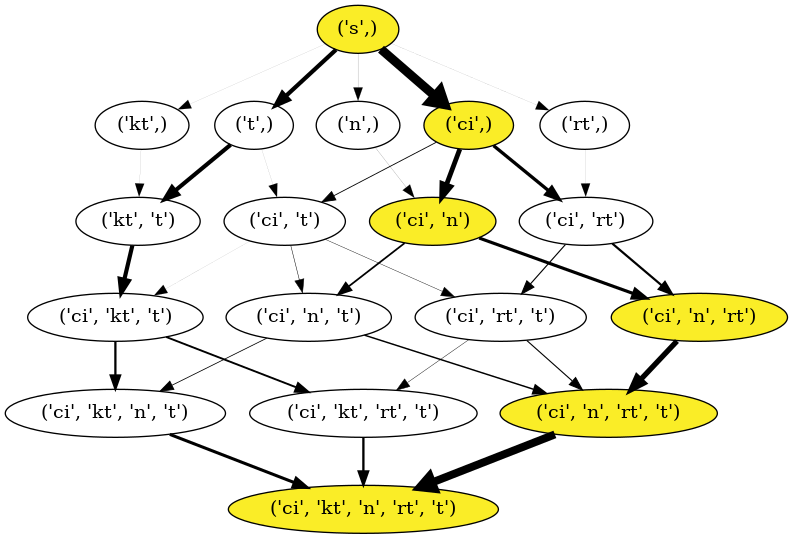

In [316]:
fn = SAVE_DIR + "SubqueryGraphQuadraticProgram.png"
plot_flow_path(edges, subsetg, qsolx, final_node, source_node, fn)

In [293]:
flow_cost, true_costs, Q2, G2, Gv2, v2, invG = debug_flow_loss(qrep, source_node, COST_KEY, COST_MODEL)
flows = Q2 @ v2
print(np.min(flows))
print(np.min(qsolx))

TypeError: get_subsetg_vectors() missing 1 required positional argument: 'cost_model'

In [213]:
print(np.allclose(costs, true_costs))
print(np.allclose(flows, qsolx))

print("actual solution off by a factor of 2")
print(prob.value*2)
print(flow_cost)

NameError: name 'true_costs' is not defined

In [209]:
plot_flow_path(edges, subsetg, flows, final_node, source_node)

NameError: name 'flows' is not defined

In [456]:
v2
np.mean(v2)

5827.691